2.2 实现一个简单的线性回归模型

In [6]:
# 真实函数缺省值为 w=1.2, b=0.5
def linear_func(x,w=1.2,b=0.5):
    y=w*x+b
    return y

In [7]:

import paddle
def create_toy_data(func, interval, sample_num, noise=0.0,add_outlier =False,outlier_ratio =0.001):
    """
    根据给定的函数，生成样本
    输入：
       - func：函数
       - interval： x的取值范围
       - sample_num： 样本数目
       - noise： 噪声均方差
       - add_outlier：是否生成异常值
       - outlier_ratio：异常值占比
    输出：
       - X: 特征数据，shape=[n_samples,1]
       - y: 标签数据，shape=[n_samples,1]
    """

    # 均匀采样
    # 使用paddle.rand在生成sample_num个随机数
    X = paddle.rand(shape=[sample_num])*(interval[1]-interval[0])+interval[0]
    y=func(X)

    # 生成高斯分布的标签噪声
    # 使用paddle.normal生成0均值，noise标准差的数据
    epsilon = paddle.normal(0,noise,paddle.to_tensor(y.shape[0]))
    y=y+epsilon
    if add_outlier:
        outlier_num = int(len(y)*outlier_ratio)
        if outlier_num != 0:
            # 使用paddle.randint生成服从均匀分布的、范围在[0, len(y))的随机Tensor
            outlier_idx = paddle.randint(len(y),shape=[outlier_num])
            y[outlier_idx] = y[outlier_idx]*5
    return X,y

In [8]:
# 利用上面的生成样本函数，生成 150 个带噪音的样本，其中 100 个训练样本，50 个测试样本，并打印出训练数据的可视化分布。

from matplotlib import pyplot as plt

func = linear_func

interval = (-10,10)
train_num =100 
test_num =50
noise =2
X_train,y_train = create_toy_data(func=func,interval=interval,sample_num=train_num,noise=noise,add_outlier=False)
X_test,y_test= create_toy_data(func=func,interval=interval,sample_num=test_num,noise=noise, add_outlier=False)

X_train_large, y_train_large = create_toy_data(func=func, interval=interval, sample_num=5000, noise = noise, add_outlier = False)

# paddle.linspace返回一个Tensor，Tensor的值为在区间start和stop上均匀间隔的num个值，输出Tensor的长度为num
X_underlying = paddle.linspace(interval[0],interval[1],train_num)
y_underlying = linear_func(X_underlying)

#绘制数据
plt.scatter(X_train,y_train,marker="*",facecolor="none",edgecolors="#e4007f",s=50,label="train data")
plt.scatter(X_test,y_test,facecolor="none",edgecolors="#f19ec2",s=50,label="test data")
plt.plot(X_underlying,y_underlying,c="#000000",label="underlying distribution")
plt.legend(fontsize = 'x-large')
plt.savefig("ml-vis.pdf")
plt.show()



<Figure size 640x480 with 1 Axes>

In [9]:
# X: tensor, shape=[N,D]
# y_pred: tensor, shape=[N]
# w: shape=[D,1]
# b: shape=[1]
# y_pred = paddle.matmul(X,w)+b
# 线性算子

In [26]:
import paddle
from op import Op

paddle.seed(20) #设置随机种子

#线性算子
class Linear(Op):
    def __init__(self,input_size):
        """
        输入：
           - input_size:模型要处理的数据特征向量长度
        """
        self.input_size = input_size

        # 模型参数

        self.params = {}
        self.params['w'] = paddle.randn(shape=[self.input_size,1],dtype='float32')
        self.params['b'] = paddle.zeros(shape=[1],dtype='float32')

    def __call__(self, X):
        return self.forward(X)
    
    # 前向函数
    def forward(self, X):
        """
        输入：
           - X: tensor, shape=[N,D]
           注意这里的X矩阵是由N个x向量的转置拼接成的，与原教材行向量表示方式不一致
        输出：
           - y_pred： tensor, shape=[N]
        """
        N,D =X.shape
        if self.input_size ==0:
            return paddle.full(shape=[N,1], fill_value=self.params['b'])
        
        assert D==self.input_size  # 输入数据维度合法性验证

        # 使用paddle.matmul计算两个tensor的乘积
        y_pred=paddle.matmul(X,self.params['w'])+self.params['b']

        return y_pred

# 注意这里我们为了和后面章节统一，这里的X矩阵是由N个x向量的转置拼接成的，与原教材行向量表示方式不一致
input_size=3
N=2
X = paddle.randn(shape=[N,input_size],dtype='float32') # 生成2个维度为3的数据
model = Linear(input_size)
y_pred =model(X)
print("y_pred:",y_pred) 

y_pred: Tensor(shape=[2, 1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[-0.05330370],
        [ 0.25675470]])


In [27]:
#损失函数
import paddle
def mean_sequared_error(y_true,y_pred):
    """
    输入：
       - y_true: tensor，样本真实标签
       - y_pred: tensor, 样本预测标签
    输出：
       - error: float，误差值
    """

    assert y_true.shape[0] == y_pred.shape[0]

    # paddle.square计算输入的平方值
    # paddle.mean沿 axis 计算 x 的平均值，默认axis是None，则对输入的全部元素计算平均值。
    error = paddle.mean(paddle.square(y_true-y_pred))

    return error

# 构造一个简单的样例进行测试:[N,1], N=2
y_true = paddle.to_tensor([[-0.2],[4.9]],dtype='float32')
y_pred = paddle.to_tensor([[1.3],[2.5]],dtype='float32')
error = mean_sequared_error(y_true=y_true,y_pred=y_pred).item()
print("error:",error)

error: 4.005000114440918


In [28]:
#模型优化
def optimizer_lsm(model,X,y,reg_lambda=0):
    """
    输入：
       - model: 模型
       - X: tensor, 特征数据，shape=[N,D]
       - y: tensor,标签数据，shape=[N]
       - reg_lambda: float, 正则化系数，默认为0
    输出：
       - model: 优化好的模型
    """

    N,D=X.shape

    # 对输入特征数据所有特征向量求平均
    x_bar_tran = paddle.mean(X,axis=0).T

    # 求标签的均值,shape=[1]
    y_bar = paddle.mean(y)

    # paddle.subtract通过广播的方式实现矩阵减向量
    x_sub = paddle.subtract(X,x_bar_tran)

    # 使用paddle.all判断输入tensor是否全0
    if paddle.all(x_sub==0):
        model.params['b'] = y_bar
        model.params['w'] = paddle.zeros(shape=[D])
        return model
    
    # paddle.inverse求方阵的逆
    tmp = paddle.inverse(paddle.matmul(x_sub.T,x_sub)+reg_lambda*paddle.eye(num_rows=(D)))

    w = paddle.matmul(paddle.matmul(tmp,x_sub.T),(y-y_bar))

    b = y_bar- paddle.matmul(x_bar_tran,w)

    model.params['w']=paddle.squeeze(w,axis=-1)
    model.params['b']=b

    return model    

In [29]:
#模型训练

#注：
# arr.shape    # (a,b)
# arr.reshape(m,-1) #改变维度为m行、d列 （-1表示列数自动计算，d= a*b /m ）
# arr.reshape(-1,m) #改变维度为d行、m列 （-1表示行数自动计算，d= a*b /m ）

input_size=1
model = Linear(input_size)
model = optimizer_lsm(model, X_train.reshape([-1,1]),y_train.reshape([-1,1]))
print("w_pred:",model.params['w'].item(),"b_pred:",model.params['b'].item())

#Tensor.item() 的作用是取出单元素张量的元素值并返回该值，保持原元素类型不变。
# 即：原张量元素为整形，则返回整形，原张量元素为浮点型则返回浮点型，etc.

y_train_pred = model(X_train.reshape([-1,1])).squeeze()
train_error = mean_sequared_error(y_true=y_train,y_pred=y_train_pred).item()
print("train_error:",train_error)

w_pred: 1.2489248514175415 b_pred: 0.4968204200267792
train_error: 4.107389450073242


In [30]:
model_large = Linear(input_size)
model_large = optimizer_lsm(model_large, X_train_large.reshape([-1,1]),y_train_large.reshape([-1,1]))
print("w_pred:",model_large.params['w'].item(),"b_pred:",model_large.params['b'].item())

y_train_pred_large = model_large(X_train_large.reshape([-1,1])).squeeze()
train_error_large = mean_sequared_error(y_true=y_train_large, y_pred=y_train_pred_large).item()
print("train error large: ",train_error_large)

w_pred: 1.1986342668533325 b_pred: 0.5359441637992859
train error large:  4.001601696014404


In [31]:
y_test_pred =model(X_test.reshape([-1,1])).squeeze()
test_error = mean_sequared_error(y_true=y_test,y_pred=y_test_pred).item()
print("test error:",test_error)

test error: 5.015231132507324


In [32]:
y_test_pred_large = model_large(X_test.reshape([-1,1])).squeeze()
test_error_large = mean_sequared_error(y_true=y_test, y_pred=y_test_pred_large).item()
print("test error large: ",test_error_large)

test error large:  4.512660026550293


In [33]:
#数据集构建
import math

# sin函数: sin(2 * pi * x)
def sin(x):
    y= paddle.sin(2*math.pi*x)
    return y

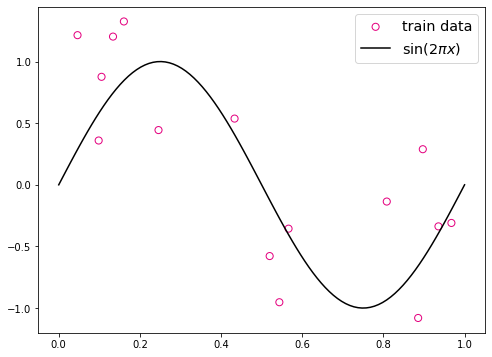

In [50]:
# 生成数据
func = sin
interval = (0,1)
train_num = 15
test_num =10
noise = 0.5 #0.1

X_train,y_train = create_toy_data(func=func,interval=interval,sample_num=train_num,noise=noise)
X_test,y_test = create_toy_data(func=func,interval=interval,sample_num=test_num,noise=noise)

X_underlying = paddle.linspace(interval[0],interval[1],num=100)
y_underlying = sin(X_underlying)

# 绘制图像
plt.rcParams['figure.figsize']=(8.0,6.0)
plt.scatter(X_train, y_train, facecolor="none", edgecolor='#e4007f', s=50, label="train data")
#plt.scatter(X_test, y_test, facecolor="none", edgecolor="r", s=50, label="test data")
plt.plot(X_underlying, y_underlying, c='#000000', label=r"$\sin(2\pi x)$")
plt.legend(fontsize='x-large')
plt.savefig('ml-vis2.pdf')
plt.show()


In [51]:
# 多项式转换

def polynomial_basis_function(x,degree = 2):
    """
    输入：
       - x: tensor, 输入的数据，shape=[N,1]
       - degree: int, 多项式的阶数
       example Input: [[2], [3], [4]], degree=2
       example Output: [[2^1, 2^2], [3^1, 3^2], [4^1, 4^2]]
       注意：本案例中,在degree>=1时不生成全为1的一列数据；degree为0时生成形状与输入相同，全1的Tensor
    输出：
       - x_result： tensor
    """
    if degree == 0:
        return paddle.ones(shape=x.shape,dtype="float32")
    
    x_tmp = x
    x_result = x_tmp
    for i in range(2,degree+1):
        # range(start, stop[, step])，分别是起始、终止和步长
        x_tmp = paddle.multiply(x_tmp,x) #逐元素相乘
        x_result = paddle.concat((x_result,x_tmp),axis=-1)

    return x_result

# 简单测试
data = [[2],[3],[4]]
X = paddle.to_tensor(data=data,dtype='float32')
degree =3
transformed_X=polynomial_basis_function(X,degree=degree)
print("转换前：",X)
print("阶数为",degree,"转换后：",transformed_X)

转换前： Tensor(shape=[3, 1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[2.],
        [3.],
        [4.]])
阶数为 3 转换后： Tensor(shape=[3, 3], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[2. , 4. , 8. ],
        [3. , 9. , 27.],
        [4. , 16., 64.]])


{'w': Tensor(shape=[1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [0.]), 'b': Tensor(shape=[1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [0.16656592])}
{'w': Tensor(shape=[1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [-1.67035925]), 'b': Tensor(shape=[1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [0.98475897])}
{'w': Tensor(shape=[3], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [-0.53839684, -8.11334229,  7.59785366]), 'b': Tensor(shape=[1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [1.11635816])}
{'w': Tensor(shape=[8], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [-23.88881111 ,  176.18946838, -494.86282349,  400.91329956,
         261.32458496, -315.29312134, -206.03846741,  200.15234375]), 'b': Tensor(shape=[1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [1.88980198])}


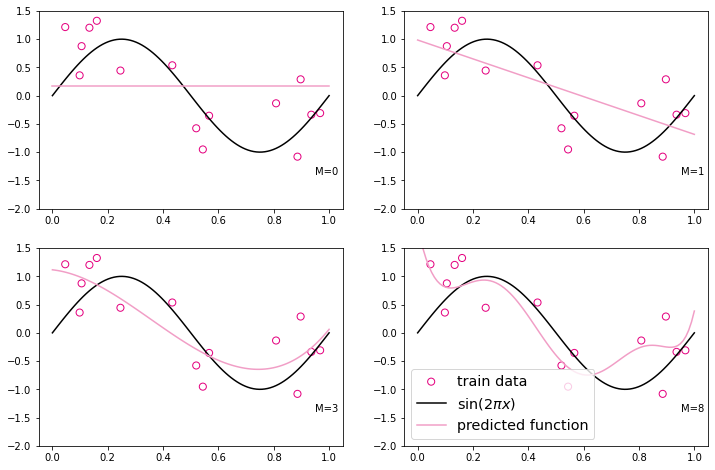

In [52]:
#模型训练
# seq = ['one', 'two', 'three']
# for i, element in enumerate(seq):
#      print i, element
# 
# Output: 0 one
#        1 two
#        2 three

plt.rcParams['figure.figsize']=(12.0,8.0)
for i, degree in enumerate([0,1,3,8]): # []中为多项式的阶数
    model = Linear(degree)
    X_train_transformed = polynomial_basis_function(X_train.reshape([-1,1]),degree)
    X_underlying_transformed =polynomial_basis_function(X_underlying.reshape([-1,1]),degree)

    model = optimizer_lsm(model,X_train_transformed,y_train.reshape([-1,1])) #拟合得到参数
    y_underlying_pred = model(X_underlying_transformed).squeeze()
    print(model.params)

    # 绘制图像
    plt.subplot(2,2,i+1)
    plt.scatter(X_train,y_train,facecolor="none",edgecolors='#e4007f',s=50,label="train data")
    plt.plot(X_underlying,y_underlying, c="#000000",label=r"$\sin(2\pi x)$")
    plt.plot(X_underlying,y_underlying_pred, c="#f19ec6", label="predicted function")
    plt.ylim(-2,1.5)
    plt.annotate("M={}".format(degree),xy=(0.95,-1.4))

#plt.legend(bbox_to_anchor=(1.05, 0.64), loc=2, borderaxespad=0.)
plt.legend(loc='lower left',fontsize='x-large')
plt.savefig('ml-vis3.pdf')
plt.show()

train errors:
 [0.5660259127616882, 0.2579406499862671, 0.18916362524032593, 0.17837215960025787, 0.16854813694953918, 0.160678893327713, 0.18742233514785767, 0.16527166962623596, 0.1598186492919922]
test errors: 
 [0.6574679017066956, 0.5934197902679443, 0.7514022588729858, 0.5765305757522583, 0.5095805525779724, 0.5920063853263855, 0.5623267292976379, 0.9444469213485718, 0.6697828769683838]
distribution errors:
 [0.5227442383766174, 0.2283812314271927, 0.27883949875831604, 0.158225879073143, 0.15394218266010284, 0.1532980054616928, 0.14899322390556335, 0.2900412380695343, 0.21800963580608368]


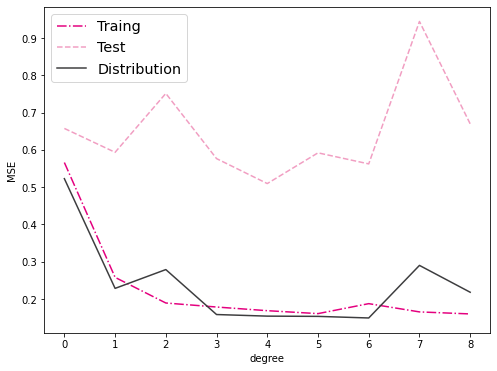

In [58]:
# 模型评估

# 训练误差和测试误差
train_errors = []
test_errors = []
distribution_errors = []

# 遍历多项式阶数
for i in range(9):
    model = Linear(i)
    X_train_transformed = polynomial_basis_function(X_train.reshape([-1,1]),i)
    X_test_transformed = polynomial_basis_function(X_test.reshape([-1,1]),i)
    X_underlying_transformed = polynomial_basis_function(X_underlying.reshape([-1,1]),i)

    optimizer_lsm(model,X_train_transformed,y_train.reshape([-1,1]))
    y_train_pred = model(X_train_transformed).squeeze()
    y_test_pred = model(X_test_transformed).squeeze()
    y_underlying_pred = model(X_underlying_transformed).squeeze()

    train_mse = mean_sequared_error(y_true=y_train,y_pred=y_train_pred).item()
    train_errors.append(train_mse)
    test_mse = mean_sequared_error(y_true=y_test,y_pred=y_test_pred).item()
    test_errors.append(test_mse)

    distribution_mse = mean_sequared_error(y_true=y_underlying, y_pred=y_underlying_pred).item()
    distribution_errors.append(distribution_mse)

print("train errors:\n",train_errors)
print("test errors: \n",test_errors)
print("distribution errors:\n", distribution_errors)

#绘制图片
plt.rcParams['figure.figsize']=(8.0,6.0)
plt.plot(train_errors,'-.',mfc = "none", mec="#e4007f", ms=10, c="#e4007f",label ="Traing")
plt.plot(test_errors, '--', mfc="none", mec='#f19ec2', ms=10, c='#f19ec2', label="Test")
plt.plot(distribution_errors, '-', mfc="none", mec="#3D3D3F", ms=10, c="#3D3D3F", label="Distribution")
plt.legend(fontsize='x-large')
plt.xlabel("degree")
plt.ylabel('MSE')
plt.savefig('ml-mse-error.pdf')
plt.show()

mse: 0.6697828769683838
mse_with_l2_reg: 0.5115095973014832


<>:31: DeprecationWarning: invalid escape sequence \e
<>:31: DeprecationWarning: invalid escape sequence \e
<>:31: DeprecationWarning: invalid escape sequence \e
<ipython-input-59-51c869b56845>:31: DeprecationWarning: invalid escape sequence \e
  plt.plot(X_underlying, y_underlying_pred_reg, c='#f19ec2', linestyle="-.", label="$deg. = 8, \ell_2 reg$")


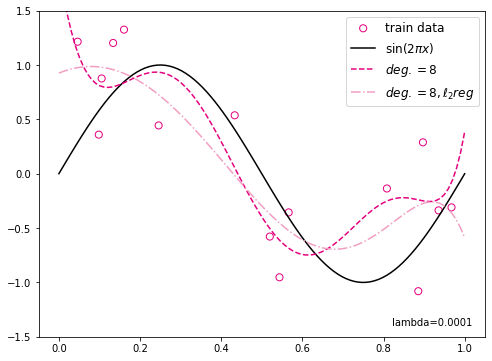

In [59]:
#对于模型过拟合的情况，可以引入正则化方法，通过向误差函数中添加一个惩罚项来避免系数倾向于较大的取值。
degree =8 #多项式阶数
reg_lambda = 0.0001 # 正则化系数
model = Linear(degree)
X_train_transformed = polynomial_basis_function(X_train.reshape([-1,1]),degree)
X_test_transformed = polynomial_basis_function(X_test.reshape([-1,1]),degree)
X_underlying_transformed = polynomial_basis_function(X_underlying.reshape([-1,1]),degree)

optimizer_lsm(model,X_train_transformed,y_train.reshape([-1,1]))

y_test_pred = model(X_test_transformed).squeeze()
y_underlying_pred = model(X_underlying_transformed).squeeze()

model_reg = Linear(degree)

optimizer_lsm(model_reg,X_train_transformed,y_train.reshape([-1,1]),reg_lambda=reg_lambda)

y_test_pred_reg = model_reg(X_test_transformed).squeeze()
y_underlying_pred_reg = model_reg(X_underlying_transformed).squeeze()

mse = mean_sequared_error(y_true=y_test,y_pred=y_test_pred).item()
print("mse:",mse)

mes_reg = mean_sequared_error(y_true=y_test,y_pred=y_test_pred_reg).item()
print("mse_with_l2_reg:",mes_reg)

# 绘制图像
plt.scatter(X_train, y_train, facecolor="none", edgecolor="#e4007f", s=50, label="train data")
plt.plot(X_underlying, y_underlying, c='#000000', label=r"$\sin(2\pi x)$")
plt.plot(X_underlying, y_underlying_pred, c='#e4007f', linestyle="--", label="$deg. = 8$")
plt.plot(X_underlying, y_underlying_pred_reg, c='#f19ec2', linestyle="-.", label="$deg. = 8, \ell_2 reg$")

plt.ylim(-1.5,1.5)
#plt.annotate()函数用于标注文字
plt.annotate("lambda={}".format(reg_lambda),xy=(0.82,-1.4))
plt.legend(fontsize='large')
plt.savefig('ml-vis4.pdf')
plt.show()
